In [36]:
import sys
sys.path.append('../')
import importlib
import model.op
importlib.reload(model.op)
from model.op import number_aircrafts_lp
from model.ParseLP import convert2df
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

# Cost Sensitivity Analysis

In [18]:
tau = np.array([[0,10,10,10],[10,0,0,0],[10,0,0,0],[10,0,0,0]])
kappa = tau

In [19]:
tau = np.array(tau) / 5
tau = np.ceil(tau)

gamma = np.array([0.0129,0.0133,0.0137,0.0142,0.0147,
                                        0.0153,0.0158,0.0166,0.0172,0.018,
                                        0.0188,0.0197,0.0207,0.0219,0.0231,
                                        0.0245,0.026,0.0278,0.03,0.0323,
                                        0.0351,0.0384,0.0423,0.0472,0.0536,
                                        0.0617,0.0726,0.0887,0.1136,0.1582,
                                        0.2622,0.9278,])*60
kappa = np.array(kappa) / (80/len(gamma))
kappa = np.ceil(kappa)
max_flight_time = int(np.max(tau))

T = 288 + 1 + max_flight_time

# Constants
K = len(gamma)

In [20]:
V = [0,1,2,3]

In [21]:
f_values = np.zeros((T, 4, 4))

In [22]:
data = pd.read_csv('../input/schedule_15min_0612.csv')
bins = np.arange(0, 24*60+1, 5)
data['time_bins'] = pd.cut(data['schedule'], bins, right=False)
counts = data.groupby(['od', 'time_bins']).size().unstack('od', fill_value=0)
LAX_DTLA = np.array(counts['LAX_DTLA'].tolist())
DTLA_LAX = np.array(counts['DTLA_LAX'].tolist())

In [24]:
for t in range(T-max_flight_time-1):
    f_values[t+1][0][1] = LAX_DTLA[t] # get the first (and only) item of the inner list
    f_values[t+1][0][2] = LAX_DTLA[t] # get the first (and only) item of the inner list
    f_values[t+1][0][3] = LAX_DTLA[t] # get the first (and only) item of the inner list

    f_values[t+1][1][0] = DTLA_LAX[t] # get the first (and only) item of the inner list
    f_values[t+1][2][0] = DTLA_LAX[t] # get the first (and only) item of the inner list
    f_values[t+1][3][0] = DTLA_LAX[t] # get the first (and only) item of the inner list

In [32]:
from gurobipy import *
m = Model("Vertiport_Aircraft_Routing")
ni = m.addVars(((t, i, k) for t in range(T) for i in V for k in range(K+1)), vtype=GRB.INTEGER, name="n")
uij = m.addVars(((t, i, j, k) for t in range(T) for i in V for j in V for k in range(K+1) if i != j), vtype=GRB.INTEGER, name="u")
cijk = m.addVars(((t, i, x, y) for t in range(T) for i in V for x in range(K+1) for y in range(K+1) if x < y), vtype=GRB.INTEGER, name="c")

m.setObjective(1*(ni.sum(0, '*', '*') + 
                uij.sum(0, '*', '*', '*') + 
                cijk.sum(0, '*', '*', '*')) + 
                0.000001*(uij.sum('*', '*', '*', '*')), GRB.MINIMIZE)

In [33]:
for i in V:
    for k in range(K+1):
        for t in range(1, T):
            m.addConstr(
                ni[t, i, k] == ni[t-1, i, k] + 
                quicksum(uij[t-tau[j][i], j, i, k+kappa[j][i]] for j in V if j != i and t-1-tau[j][i] >= 0 and k+kappa[j][i] <= K) -
                quicksum(uij[t, i, j, k] for j in V if j != i) +
                quicksum(cijk[t-np.ceil(sum(gamma[x:k])/5), i, x, k] for x in range(k) if t-np.ceil(sum(gamma[x:k])/5) >= 0) -
                quicksum(cijk[t, i, k, y] for y in range(k+1, K+1))
            )

In [34]:
for k in range(K+1):
    for i in V:
        m.addConstr(ni[0, i, k] == ni[288+max_flight_time, i, k])
        for j in V:
            if i != j:
                m.addConstr(uij[0, i, j, k] == uij[288+max_flight_time, i, j, k])
        
for x in range(K+1):
    for y in range(K+1):
        for i in V:
            if (x < y):
                m.addConstr(cijk[0, i, x, y] == cijk[288+max_flight_time, i, x, y])
                
for j in V:
    for i in V:
        if i != j:
            for t in range(T-1):
                m.addConstr(uij.sum(t, i, j, '*') >= f_values[t][i][j])

# Can't fly when SOC = 0
for i in V:
    for j in V:
        for t in range(T):
            if i != j:
                m.addConstr(uij[t, i, j, 0] == 0)

# Integrate new variables
m.update()

m.Params.MIPGap = 0.05  # Set the optimality tolerance to 5%
m.Params.FeasibilityTol = 1e-7
# Solve model
m.optimize()

# Print results
for v in m.getVars():
    if v.x > 0:  # Print only non-zero variables for clarity
        print('{} = {}'.format(v.varName, v.x))

# Calculate the total fleet size and store it in a variable
total_fleet_size = ni.sum(0, '*', '*').getValue() + uij.sum(0, '*', '*', '*').getValue() + cijk.sum(0, '*', '*', '*').getValue()

# Print the total fleet size
print('Total Fleet Size:', total_fleet_size)

Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 47892 rows, 768240 columns and 1636792 nonzeros
Model fingerprint: 0x5c844726
Variable types: 0 continuous, 768240 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 8287 rows and 17601 columns
Presolve time: 1.85s
Presolved: 39605 rows, 750639 columns, 1539654 nonzeros
Variable types: 0 continuous, 750639 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.60s

Barrier statistics:
 AA' NZ     : 3.641e+05
 Factor NZ  : 6.165e+06 (roughly 200 MB of memory)
 Factor

In [42]:
with open(f'../output/hubspoke_fleetsize.txt', 'w') as file:
    # Redirect standard output to the file
    old_stdout = sys.stdout
    sys.stdout = file
    print("results")
    # Check variable values and write them to the file
    for v in m.getVars():
        if v.x > 0:  # Print only non-zero variables for clarity
            print('{} = {}'.format(v.varName, v.x))

    # Restore standard output
    sys.stdout = old_stdout

In [35]:
with open(f'../output/hubspoke_fleetsize.txt', 'w') as file:
    file.write('Total Fleet Size: ' + str(total_fleet_size))

In [46]:
specificn, specificu, specificc = convert2df('hubspoke_fleetsize')

In [47]:
specificc

,t,i,x,y,amount,name
0,0,0,1,7,1.0,c
1,0,0,1,26,1.0,c
2,0,0,2,4,1.0,c
3,0,0,3,4,2.0,c
4,0,0,16,18,2.0,c
...,...,...,...,...,...,...
2000,290,2,11,12,1.0,c
2001,290,2,23,32,1.0,c
2002,290,3,7,15,2.0,c
2003,290,3,8,28,1.0,c


In [8]:
output_file = 'cost_ratio_04_10min'
number_aircrafts_lp(schedule='schedule_10min_0610', schedule_time_step=288, output_path=output_file, tau= variable_cost=0)
specificn, specificu, specificc = convert2df('output_file')
print('Total # of flights is', specificu['amount'].sum())

NameError: name 'convert2df' is not defined

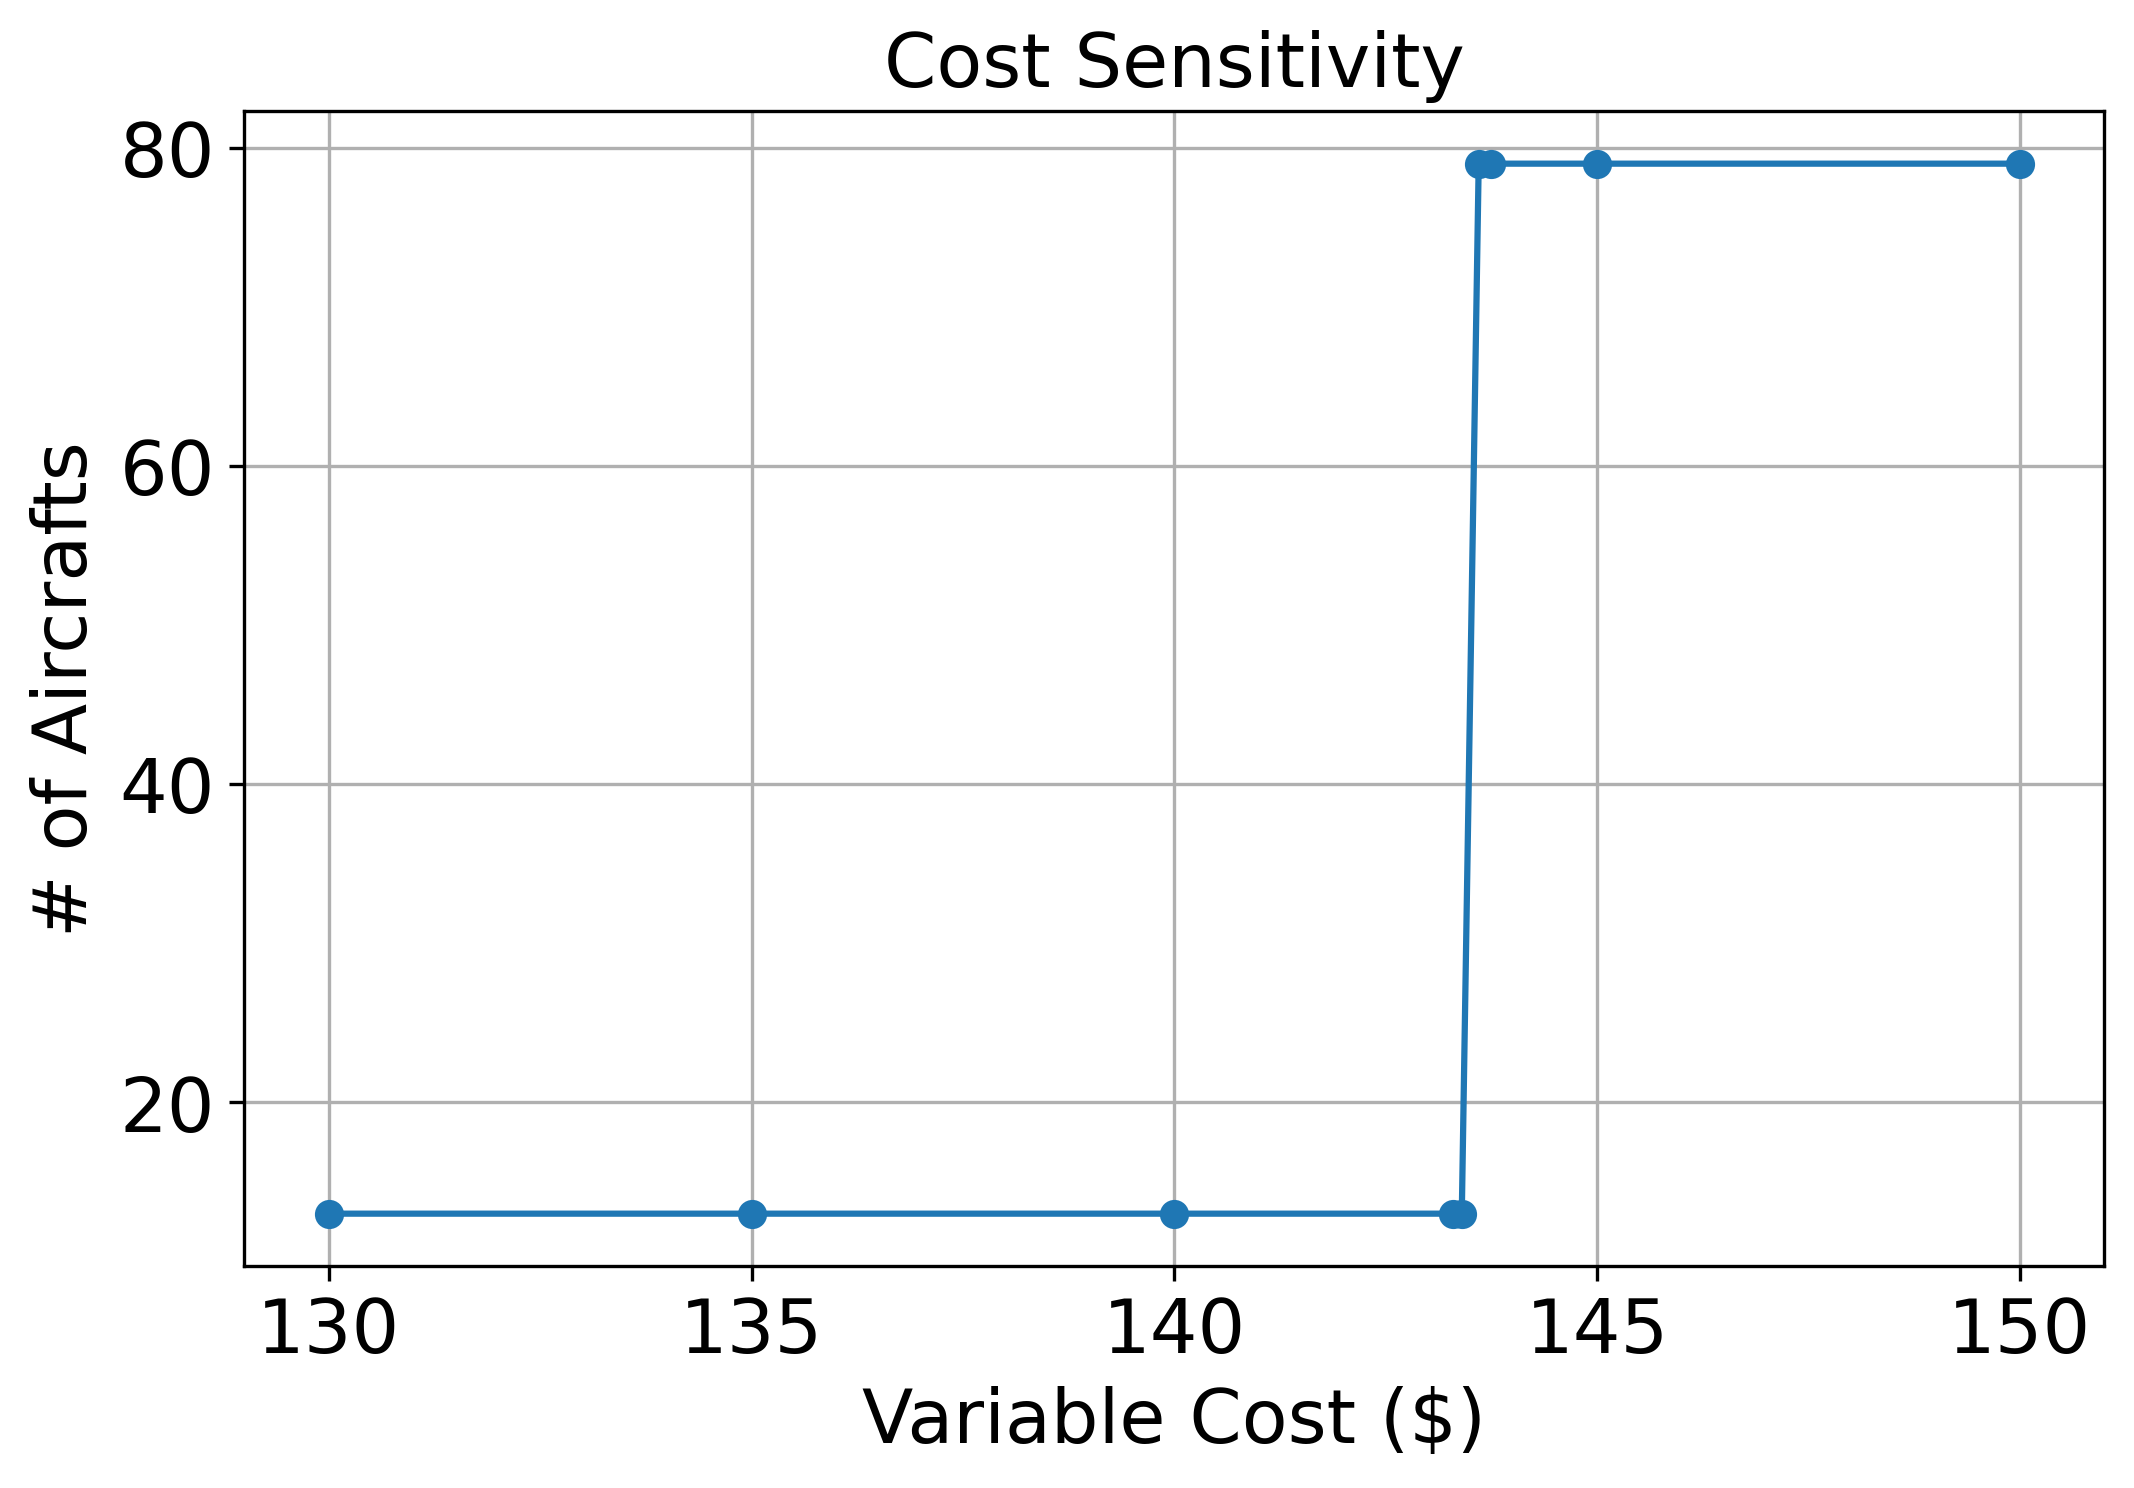

In [24]:
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
fig, ax = plt.subplots(figsize=(8,5))
vc = [130, 135, 140, 143.3, 143.4, 143.6, 143.75, 145, 150]
n = [13, 13, 13, 13, 13, 79,79,79,79]
ax.plot(vc,n,marker='o')
ax.set(xlabel='Variable Cost ($)', 
       ylabel='# of Aircrafts',
       title='Cost Sensitivity')
plt.grid()
plt.gcf().set_dpi(300)

In [27]:
schedule = pd.read_csv('../input/schedule_5min_0612.csv')
schedule.shape

(771, 2)

In [52]:
specificn, specificu60, specificc = convert2df('output_60_miles_5min_DTLA_charging')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns

In [34]:
def find_repo_flights(specificu):

    lp_out = specificu.groupby(['t', 'i']).sum('amount').reset_index()
    lp_out.loc[lp_out['i'] == 0, 'i'] = 'LAX_DTLA'
    lp_out.loc[lp_out['i'] == 1, 'i'] = 'DTLA_LAX'
    schedule = pd.read_csv('../input/schedule_5min_0612.csv')
    schedule['schedule'] = np.ceil(schedule['schedule'] / 5)
    schedule = schedule.groupby(['schedule', 'od']).size().reset_index()
    schedule.columns = ['schedule', 'od', 'schedule_amount']
    merged = schedule.merge(lp_out, how='outer',left_on=['od','schedule'], right_on=['i', 't'])
    merged['repo'] = merged['amount'] - merged['schedule_amount']

    return merged

In [53]:
merged36 = find_repo_flights(specificu=specificu36)
merged48 = find_repo_flights(specificu=specificu48)
merged60 = find_repo_flights(specificu=specificu60)

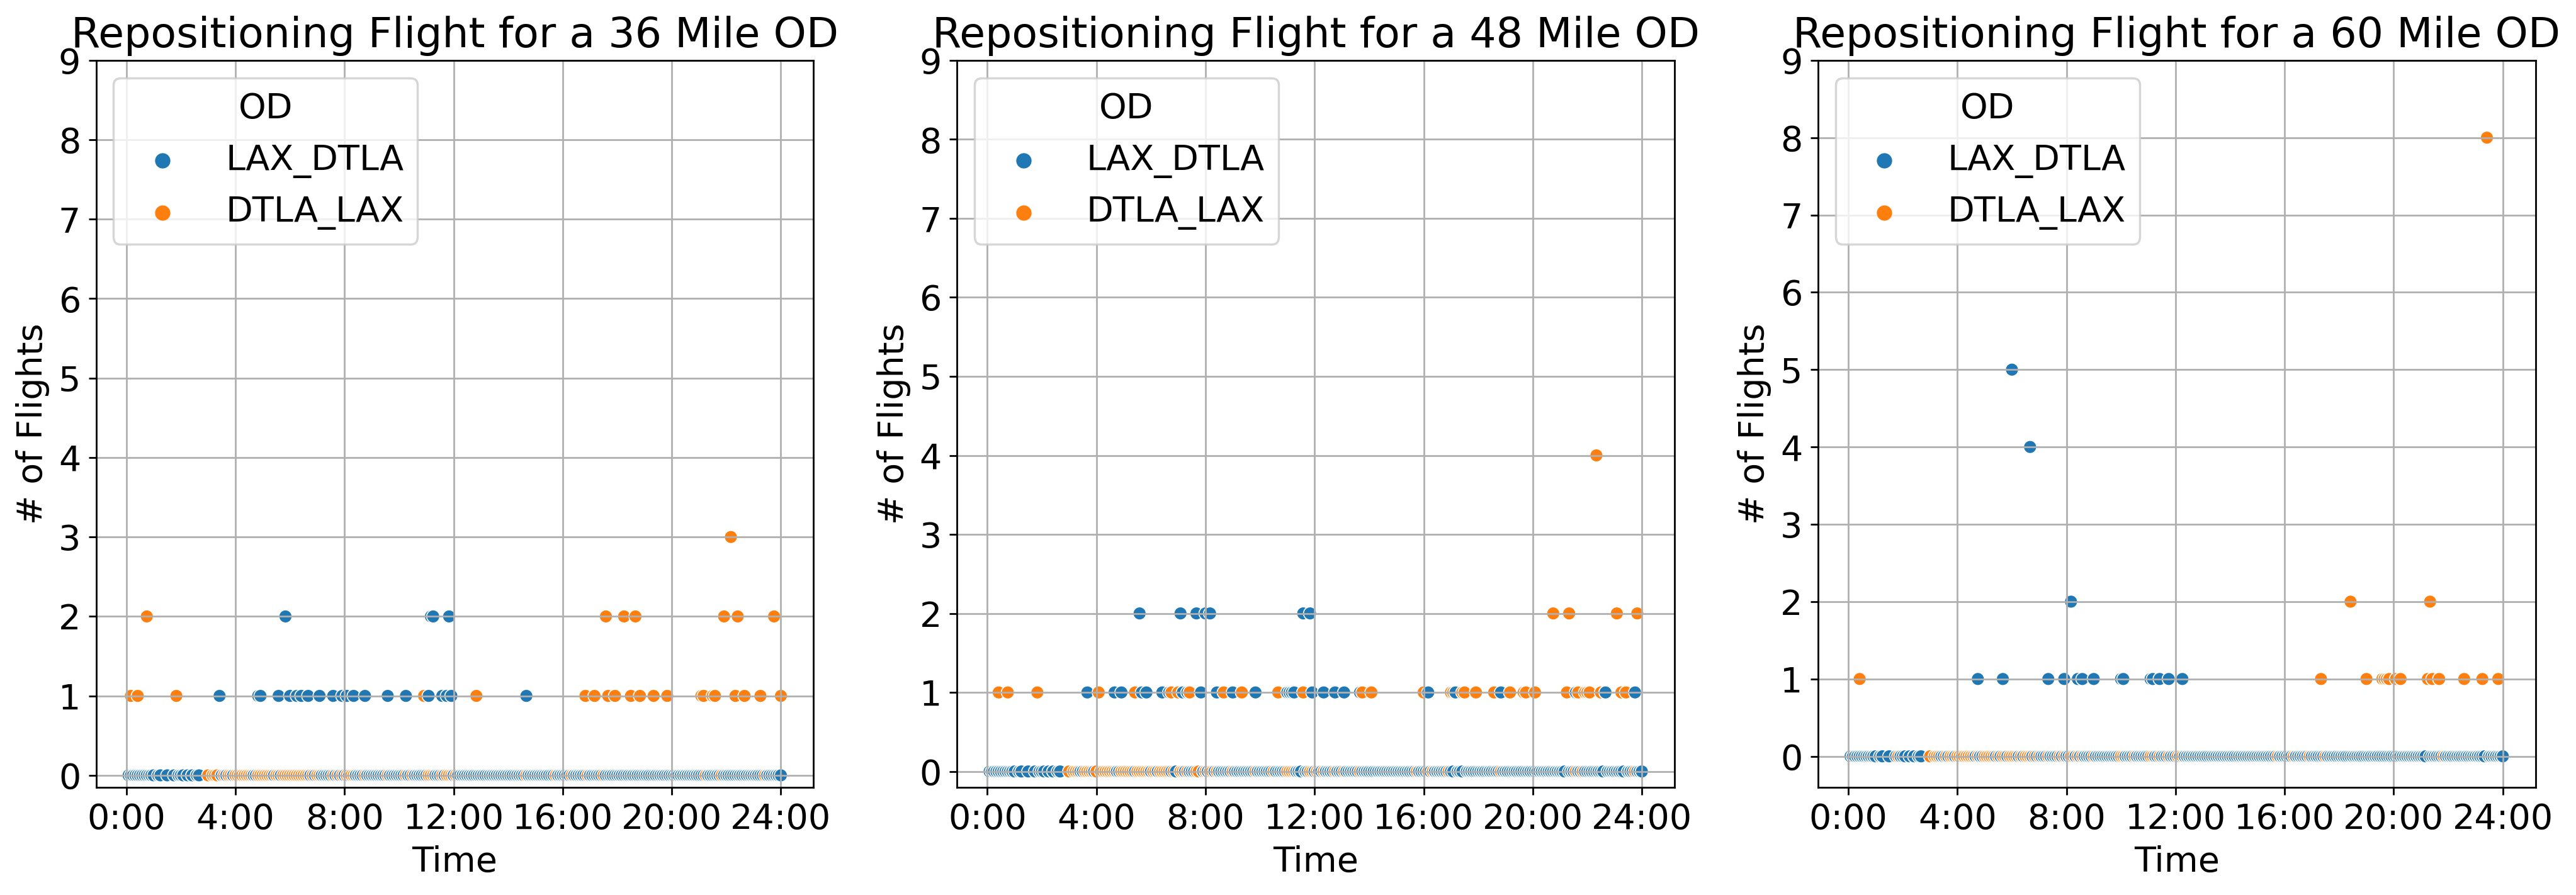

In [69]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(20,6), ncols=3)
sns.scatterplot(merged36, x='t', y='repo', hue='i', ax=ax[0])
sns.scatterplot(merged48, x='t', y='repo', hue='i', ax=ax[1])
sns.scatterplot(merged60, x='t', y='repo', hue='i', ax=ax[2])
for i in range(3):
       ax[i].set(xlabel='Time',
              ylabel='# of Flights',
              yticks=np.arange(0,10),
              xticks=np.arange(0,288+12*4, 12*4),
              xticklabels = [str(i)+':00' for i in range(0, 28, 4)])
       ax[i].grid()
       ax[i].legend(title='OD', loc='upper left')
ax[0].set(title='Repositioning Flight for a 36 Mile OD')
ax[1].set(title='Repositioning Flight for a 48 Mile OD')
ax[2].set(title='Repositioning Flight for a 60 Mile OD')


plt.gcf().set_dpi(250)



# Hypothetical Flight Distance

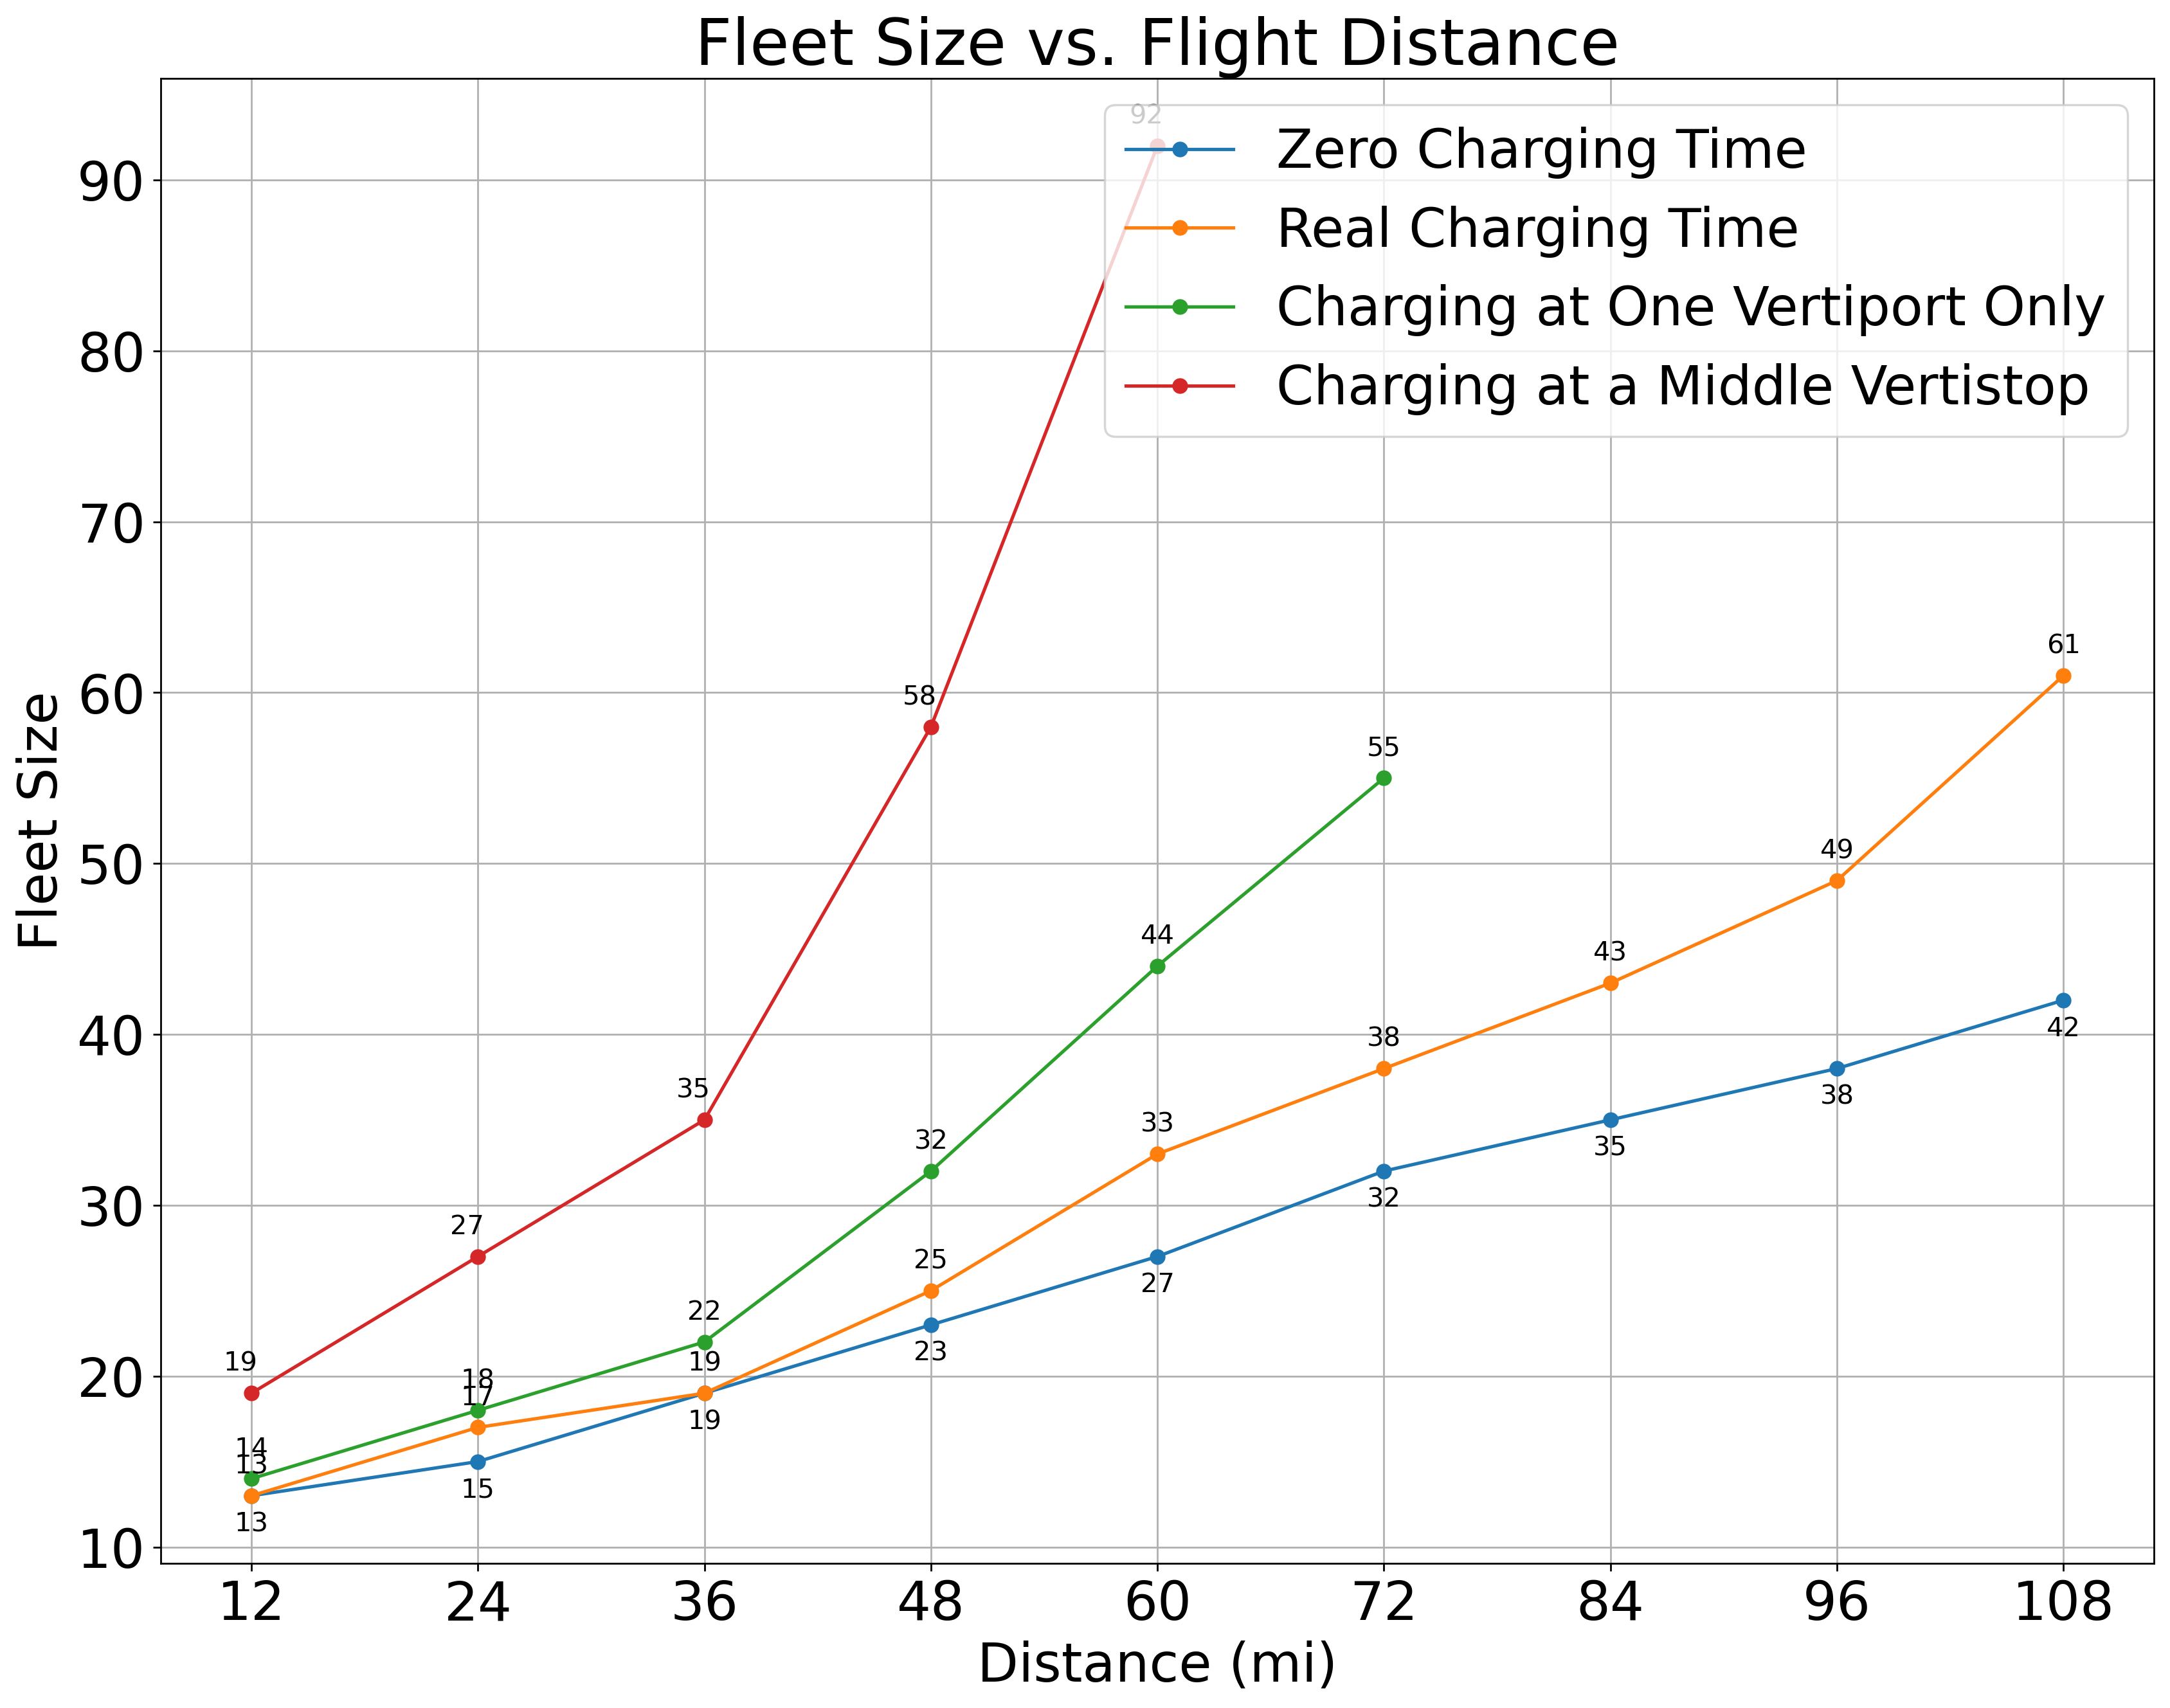

In [103]:
zero_charge = [13,15,19,23,27,32,35,38,42]
real_charge = [13,17,19,25,33,38,43,49,61]
dtla_charge = [14,18,22,32,44,55]
mid = [19,27,35,58,92]
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(np.arange(12,120,12), zero_charge, marker='o',
         label='Zero Charging Time')
ax.plot(np.arange(12,120,12), real_charge, marker='o',
         label='Real Charging Time')
ax.plot(np.arange(12,84,12), dtla_charge, marker='o',
         label='Charging at One Vertiport Only')
ax.plot(np.arange(12,72,12), mid, marker='o',
         label='Charging at a Middle Vertistop')

for i in range(len(zero_charge)):
    plt.annotate(zero_charge[i], (np.arange(12,120,12)[i], zero_charge[i]), textcoords="offset points", xytext=(0,-16), ha='center', fontsize=12)
for i in range(len(real_charge)):
    plt.annotate(real_charge[i], (np.arange(12,120,12)[i], real_charge[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
for i in range(len(dtla_charge)):
    plt.annotate(dtla_charge[i], (np.arange(12,84,12)[i], dtla_charge[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
for i in range(len(mid)):
    plt.annotate(mid[i], (np.arange(12,72,12)[i], mid[i]), textcoords="offset points", xytext=(-5,10), ha='center', fontsize=12)
ax.set(xlabel='Distance (mi)',
       ylabel='Fleet Size',
       xticks=np.arange(12,120,12),
       title='Fleet Size vs. Flight Distance')
plt.grid()
plt.legend()
plt.gcf().set_dpi(250)


# Import Helper Functions

In [51]:
import model.ParseLP
importlib.reload(model.ParseLP)
from model.ParseLP import convert2df, calculate_num_aircrafts

# Testing

<AxesSubplot:xlabel='t', ylabel='amount'>

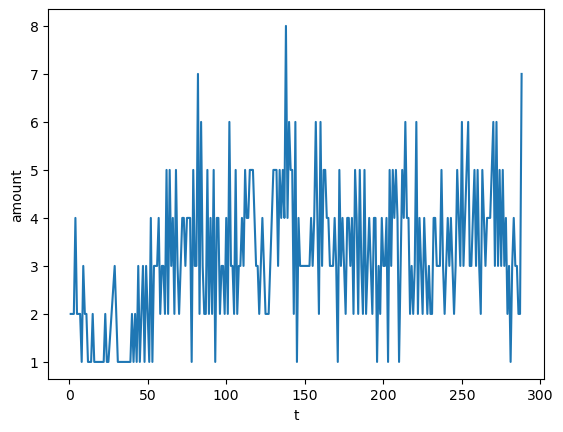

In [190]:
# output_file = 'variable_values'
output_file = 'cost_ratio_04'
specificn, specificu, specificc = convert2df(output_file)
test = specificu.groupby('t').sum('amount').reset_index()
sns.lineplot(x=test['t'], y=test['amount'])

In [49]:
# Obtain Airport Specific Aircraft States
specificu01 = specificu[specificu['i'] == 0].reset_index(drop=True)
specificu10 = specificu[specificu['i'] == 1].reset_index(drop=True)
specificu20 = specificu[specificu['i'] == 2].reset_index(drop=True)
specificu30 = specificu[specificu['i'] == 3].reset_index(drop=True)

specificc01 = specificc[specificc['i'] == 0].reset_index(drop=True)
specificc10 = specificc[specificc['i'] == 1].reset_index(drop=True)
specificc20 = specificc[specificc['i'] == 2].reset_index(drop=True)
specificc30 = specificc[specificc['i'] == 3].reset_index(drop=True)


specificn01 = specificn[specificn['i'] == 0].reset_index(drop=True)
specificn10 = specificn[specificn['i'] == 1].reset_index(drop=True)
specificn20 = specificn[specificn['i'] == 2].reset_index(drop=True)
specificn30 = specificn[specificn['i'] == 3].reset_index(drop=True)


In [58]:
lax_all_c, lax_all_n, lax_all_u = calculate_num_aircrafts(specificc01, specificu01, specificn01)
dtla_all_c, dtla_all_n, dtla_all_u = calculate_num_aircrafts(specificc10, specificu10, specificn10)
dtla_all_c2, dtla_all_n2, dtla_all_u2 = calculate_num_aircrafts(specificc20, specificu20, specificn20)
dtla_all_c3, dtla_all_n3, dtla_all_u3 = calculate_num_aircrafts(specificc30, specificu30, specificn30)


all_c, all_n, all_u = calculate_num_aircrafts(specificc, specificu, specificn, flight_time=tau)

IndexError: index 2 is out of bounds for axis 1 with size 2

array([[0., 2., 2., 2.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.]])

# State Visulization

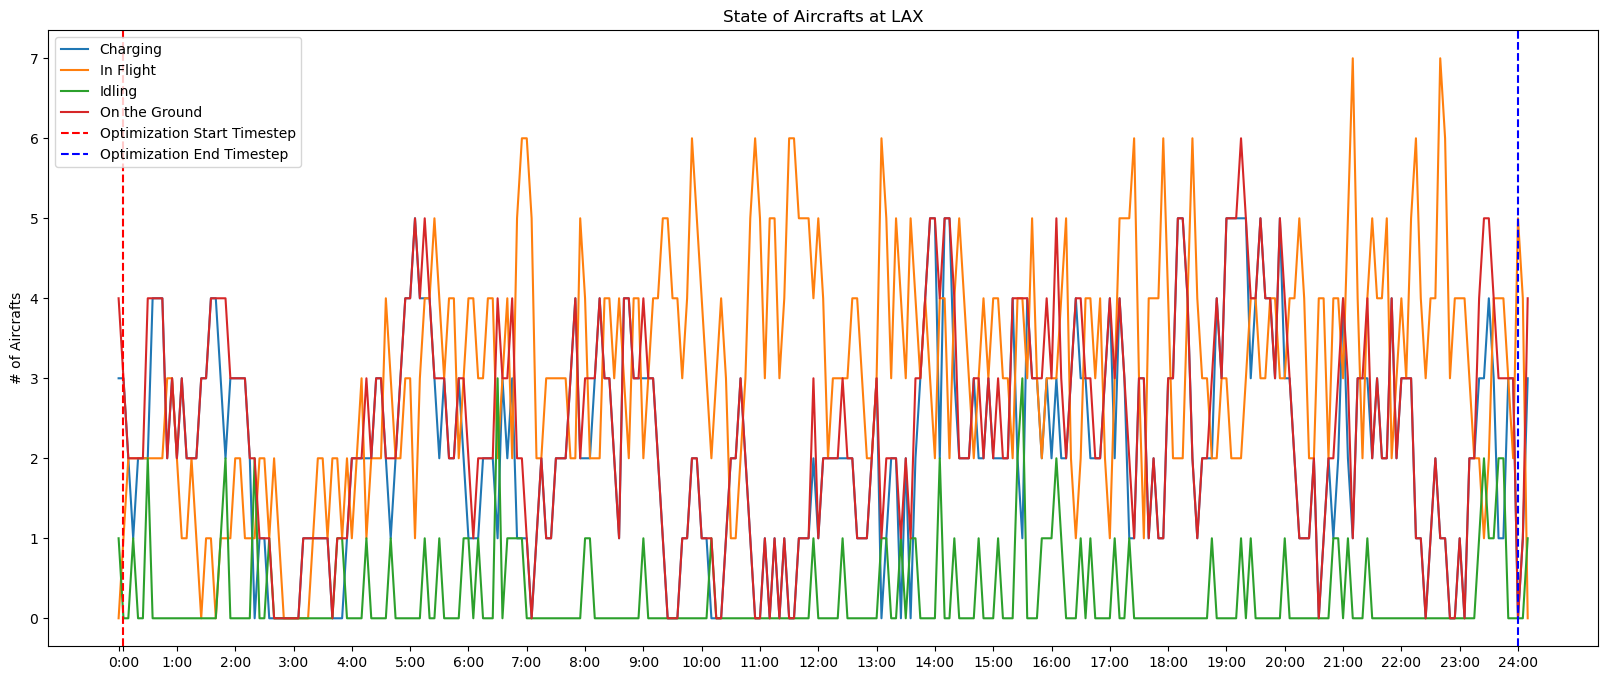

In [178]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(lax_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(lax_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(lax_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at LAX',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

In [179]:
print('At t = 0, c =', lax_all_c.sum(axis=0)[x0:x1][0], '; u=', lax_all_u.sum(axis=0)[x0:x1][0], '; n=', lax_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', lax_all_c.sum(axis=0)[x0:x1][290], '; u=', lax_all_u.sum(axis=0)[x0:x1][290], '; n=', lax_all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 3.0 ; u= 0.0 ; n= 1.0
At t = 290, c = 3.0 ; u= 0.0 ; n= 1.0


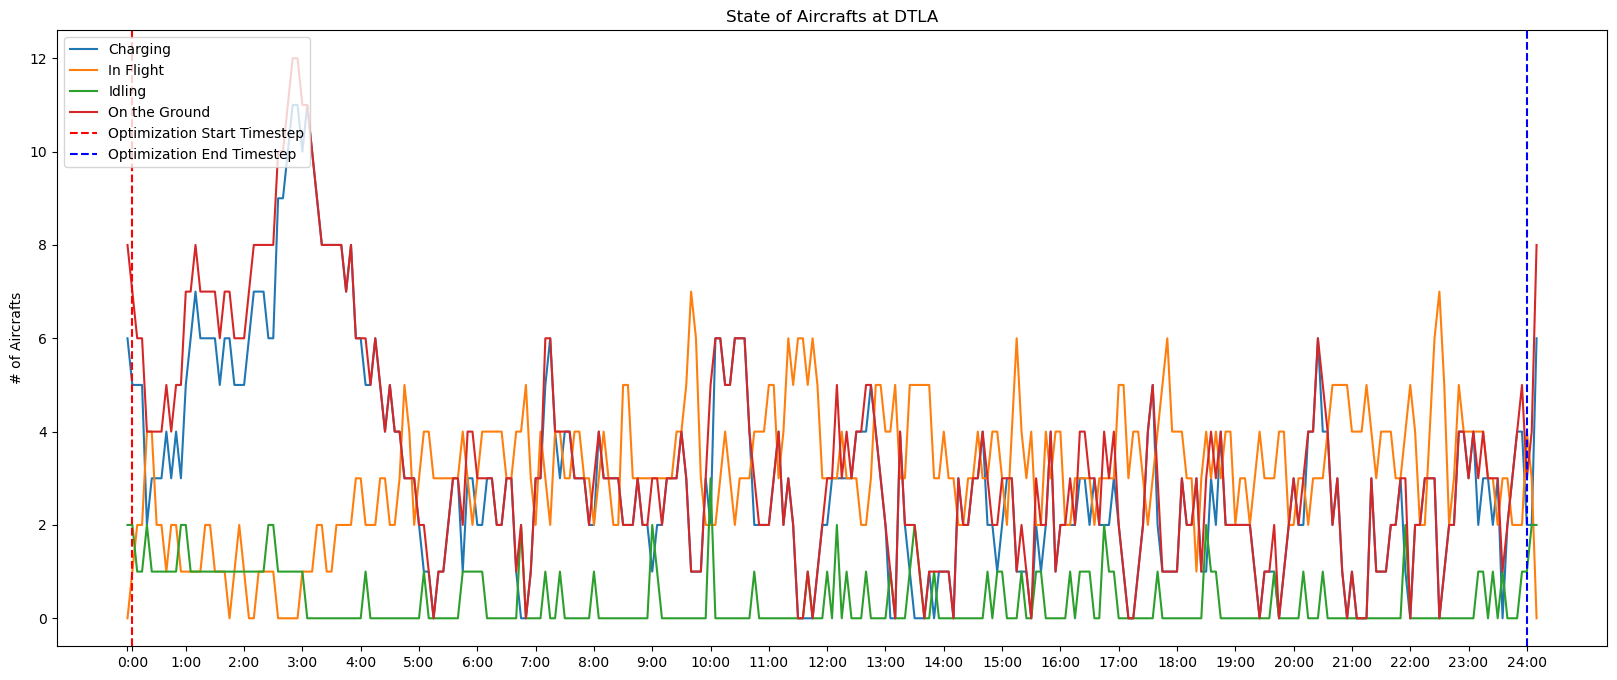

In [180]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(dtla_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(dtla_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(dtla_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at DTLA',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

In [181]:
print('At t = 0, c =', dtla_all_c.sum(axis=0)[x0:x1][0], '; u=', dtla_all_u.sum(axis=0)[x0:x1][0], '; n=', dtla_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', dtla_all_c.sum(axis=0)[x0:x1][290], '; u=', dtla_all_u.sum(axis=0)[x0:x1][290], '; n=', dtla_all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 6.0 ; u= 0.0 ; n= 2.0
At t = 290, c = 6.0 ; u= 0.0 ; n= 2.0


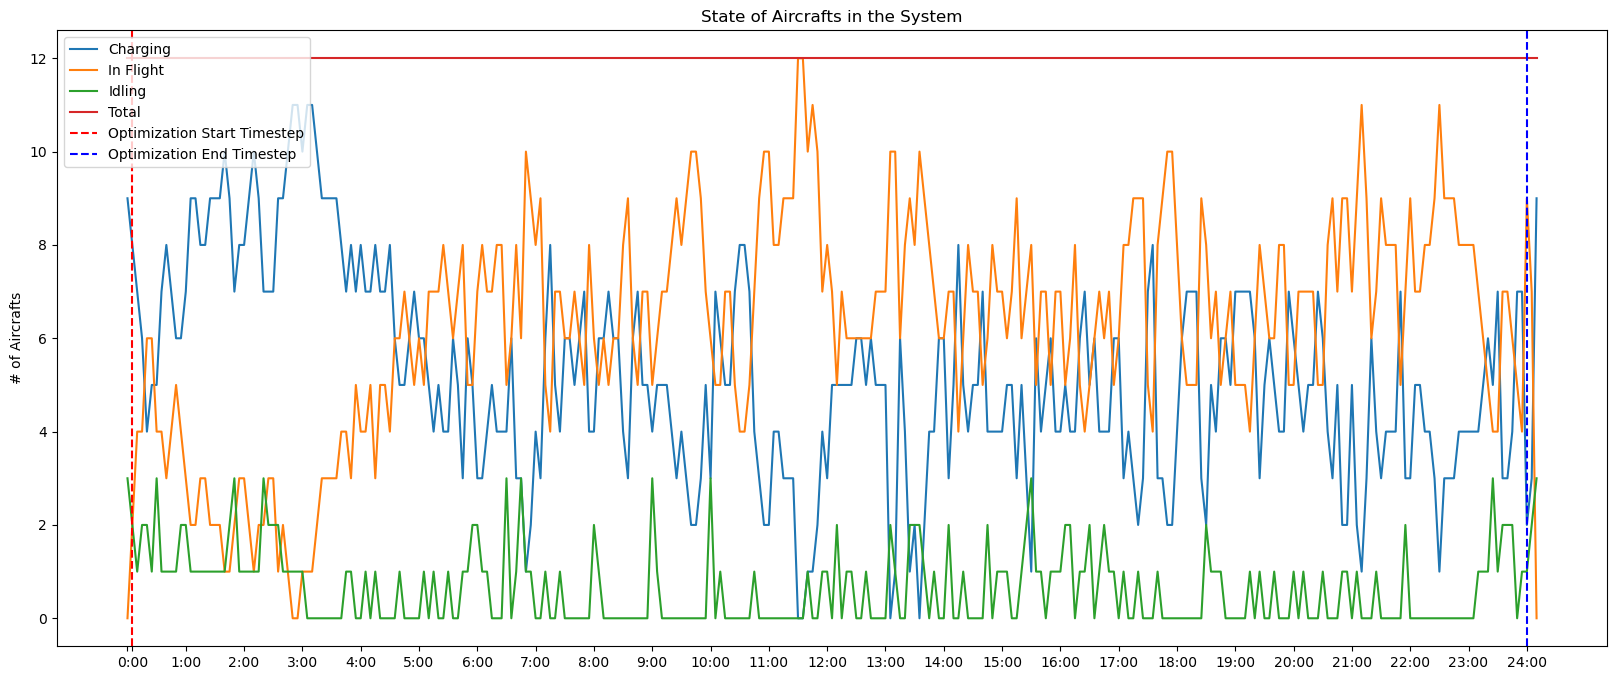

In [182]:
x0=0
x1=291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts in the System',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

In [183]:
print('At t = 0, c =', all_c.sum(axis=0)[x0:x1][0], '; u=', all_u.sum(axis=0)[x0:x1][0], '; n=', all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', all_c.sum(axis=0)[x0:x1][290], '; u=', all_u.sum(axis=0)[x0:x1][290], '; n=', all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 9.0 ; u= 0.0 ; n= 3.0
At t = 290, c = 9.0 ; u= 0.0 ; n= 3.0


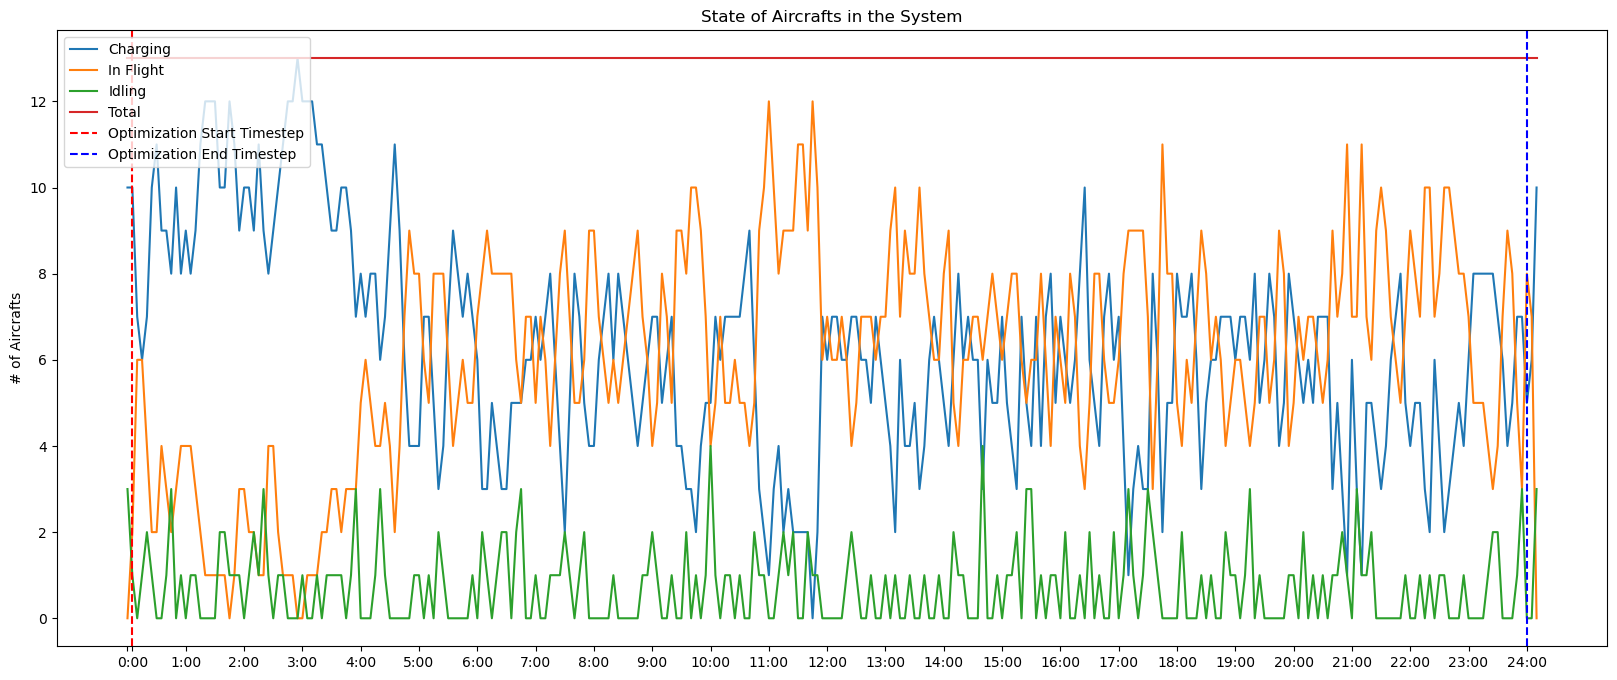

In [186]:
all_c, all_n, all_u = calculate_num_aircrafts(specificc, specificu, specificn)
x0=0
x1=291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts in the System',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

<AxesSubplot:xlabel='t', ylabel='amount'>

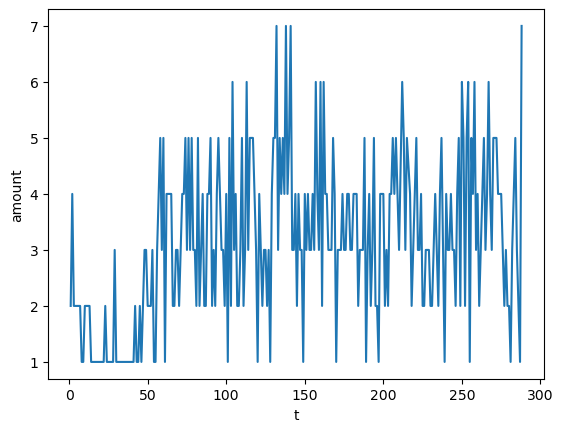

In [189]:
test = specificu.groupby('t').sum('amount').reset_index()
sns.lineplot(x=test['t'], y=test['amount'])

# Cost Ratio Analysis

In [21]:
# A flight cost is 100 dollars, an aircraft is 2.2M


cost_ratio = np.array([0.3, 0.4, 0.5, 0.55, 0.6])
num_aircraft = np.array([12, 12, 19, 75, 75])

[Text(0.5, 0, 'Cost per Flight / Per Aircraft Ownership'),
 Text(0, 0.5, 'Minimum # of Aircrafts'),
 Text(0.5, 1.0, '# of Aircrafts Considering DOC ')]

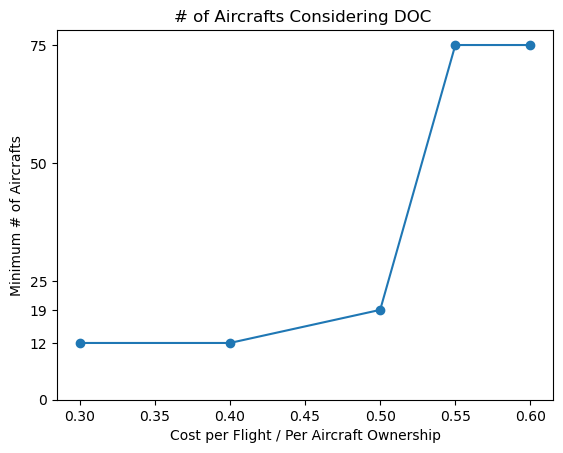

In [22]:
fig, ax = plt.subplots()
ax.plot(cost_ratio, num_aircraft, marker='o')
ax.set(yticks=[0,12,19,25,50,75])
ax.set(xlabel="Cost per Flight / Per Aircraft Ownership",
       ylabel='Minimum # of Aircrafts',
       title='# of Aircrafts Considering DOC ')

In [ ]:
381, 388

In [57]:
143.5/287

0.5

In [ ]:
schedule_5minute = pd.read_csv('../input/schedule_5min_06')